# exp006

In [69]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

sns.set_style("darkgrid")
%matplotlib inline

## データセットの読み込み

In [70]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## 実験設定

In [97]:
class CONFIG:
    seed = 42
    n_splits = 5
    num_boost_round = 10000
    early_stopping_rounds = 10
    learning_rate = 0.001
    objective = "regression"
    max_depth = 5
    num_leaves = 32
    period = 1000
    exp_id = "006"
    model_path = Path(f"../output/model{exp_id}")
    model_path.mkdir(parents=True, exist_ok=True)
    submission_path = Path(f"../output/submission")

## RMSLEの定義

In [72]:
def feval_rmsle(preds, data):
    y_true = data.get_label()
    preds = np.clip(preds, 0, None)  # 0より小さい値を0に置換
    rmsle = np.sqrt(mean_squared_log_error(y_true, preds))
    return 'RMSLE', rmsle, False

## 特徴量エンジニアリング

In [73]:
df = pd.concat([train_df, test_df], axis=0, sort=False).reset_index(drop=True)
df = df.drop(["casual", "registered"], axis=1)

In [74]:
datetime = pd.to_datetime(df["datetime"])
df["year"] = datetime.dt.year
df["month"] = datetime.dt.month
df["day"] = datetime.dt.day
df["hour"] = datetime.dt.hour
df["dayofweek"] = datetime.dt.day_name()
df["dayofweek"] = df["dayofweek"].map({"Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6})
df = df.drop("datetime", axis=1)

In [75]:
df["count"] = df["count"].apply(lambda x: np.log(x))

In [84]:
df['peak'] = df[['hour', 'workingday']].apply(lambda x: 1 if (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) \
                                        or (x['workingday'] == 0 and 10 <= x['hour'] <= 19) else 0, axis=1)

In [85]:
train_df = df[~df["count"].isnull()].reset_index(drop=True)
test_df = df[df["count"].isnull()].drop("count", axis=1).reset_index(drop=True)

## train

In [86]:
def train(df, model_path):
    kf = KFold(n_splits=CONFIG.n_splits, shuffle=True, random_state=CONFIG.seed)
    fold_rmsles = []

    for fold, (train_index, valid_index) in enumerate(kf.split(df)):
        print(f"start training for fold {fold}")

        X_train = df.iloc[train_index].drop(["count"], axis=1)
        y_train = df.iloc[train_index]["count"]

        X_valid = df.iloc[valid_index].drop(["count"], axis=1)
        y_valid = df.iloc[valid_index]["count"]

        print("start training")
        params = {
            "objective": CONFIG.objective,
            "seed": CONFIG.seed,
            "learning_rate": CONFIG.learning_rate,
            "num_leaves": CONFIG.num_leaves,
            "max_depth": CONFIG.max_depth,
        }

        train_set = lgb.Dataset(X_train, y_train)
        valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

        model = lgb.train(
            params=params,
            train_set=train_set,
            valid_sets=[train_set, valid_set],
            num_boost_round=CONFIG.num_boost_round,
            feval=feval_rmsle,
            callbacks=[
                lgb.early_stopping(stopping_rounds=CONFIG.early_stopping_rounds, verbose=True),
                lgb.log_evaluation(period=CONFIG.period)
            ]
        )

        print(f"predict valid for fold {fold}")
        y_pred = model.predict(X_valid)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        y_valid = np.exp(y_valid)

        fold_rmsles.append(np.sqrt(mean_squared_log_error(y_valid, y_pred)))

        print(f"save model for fold {fold}")
        model.save_model(model_path / f"model_fold{fold+1:03d}.bin", num_iteration=model.best_iteration)

    return sum(fold_rmsles) / len(fold_rmsles)

In [87]:
train_rmsle = train(train_df, CONFIG.model_path)
print(f"RMSLE: {train_rmsle}")

start training for fold 0
start training
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 296
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 14
[LightGBM] [Info] Start training from score 4.555325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

## evaluate

In [88]:
def evaluate(df, model_path):
    predictions = []

    for fold in range(CONFIG.n_splits):
        print(f"loading model for fold {fold}")
        model = lgb.Booster(model_file=model_path / f"model_fold{fold+1:03d}.bin")

        print(f"start evaluate for fold {fold}")
        X_test = df.copy()

        print(f"predict test for fold {fold}")
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_pred = np.clip(y_pred, 0, None)
        y_pred = np.exp(y_pred)
        predictions.append(y_pred)
    
    average_predictions = np.mean(predictions, axis=0)
    return average_predictions

In [89]:
y_pred = evaluate(test_df, CONFIG.model_path)
y_pred

loading model for fold 0
start evaluate for fold 0
predict test for fold 0
loading model for fold 1
start evaluate for fold 1
predict test for fold 1
loading model for fold 2
start evaluate for fold 2
predict test for fold 2
loading model for fold 3
start evaluate for fold 3
predict test for fold 3
loading model for fold 4
start evaluate for fold 4
predict test for fold 4


array([ 11.14593183,   5.20948525,   3.1159037 , ..., 132.6331581 ,
       103.85909756,  56.81268762])

In [98]:
submission = pd.read_csv(input_path / "sampleSubmission.csv")
submission["count"] = y_pred
submission.to_csv(CONFIG.submission_path / f"submission{CONFIG.exp_id}.csv", index=False)

## Result

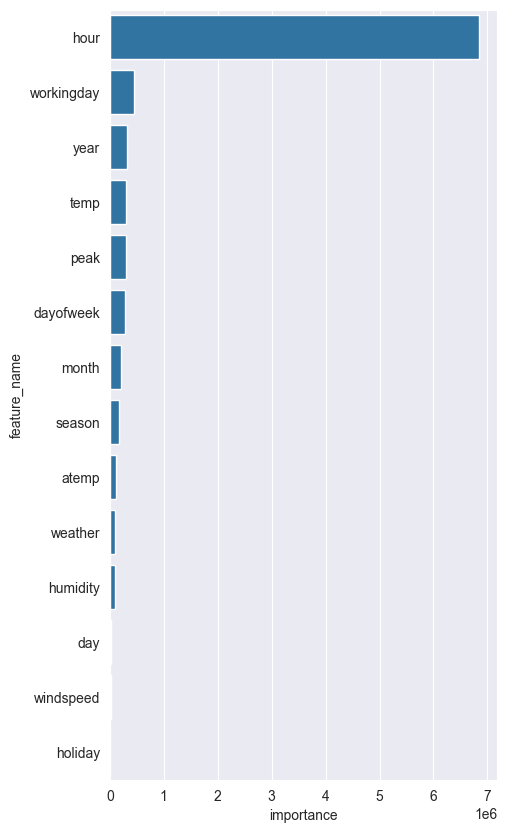

In [96]:
model = lgb.Booster(model_file=CONFIG.model_path / f"model_fold001.bin")
importance_df = pd.DataFrame()

importance_df["importance"] = model.feature_importance(importance_type="gain")
importance_df["feature_name"] = model.feature_name()
importance_df = importance_df.sort_values("importance", ascending=False)

fig = plt.figure(figsize=(5, 10))
sns.barplot(data=importance_df, x="importance", y="feature_name")
plt.show()